# Donders MML: XDF processing
The script processes all data files sotred in an XDF format. 
Steps: 
1. Import libraries necessary for processing audio, video and data files 
    a. See requirements.txt to conda install all the necessary packages. 
    
2. Identify XDF files within a specified directory or its subdirectories.




## 0. Import all the necessary packages to work with XDF files 

In [29]:
import os  # Importing the os module which provides functions for interacting with the operating system
import pyxdf  # Importing pyxdf, a Python library for reading XDF files
import glob  # Importing the glob module which helps in finding files/directories with specific patterns
import pandas as pd  # Importing pandas library (abbreviated as pd), which is used for data manipulation and analysis
import numpy as np  # Importing numpy library (abbreviated as np), which is used for numerical computations
import wave  # Importing wave module for reading and writing WAV files (usually audio files) 
import struct  # Importing struct module which provides functions to convert between Python values and C structs
import math  # Importing math module which provides mathematical functions
import random  # Importing random module for generating random numbers
from scipy.io import wavfile  # Importing wavfile module from scipy.io (a library built on numpy), for reading and writing WAV files
import noisereduce as nr  # Importing noisereduce module for noise reduction in audio signals
import json  # Importing json module for working with JSON data
import cv2  # Importing OpenCV library for computer vision tasks
from moviepy.editor import (  # Importing various classes and functions from moviepy.editor module
                            VideoFileClip,  # Class for working with video files
                            AudioFileClip,  # Class for working with audio files
                            CompositeAudioClip)  # Class for composing audio clip

print("Everything was imported succesfully") #as terminal

Everything was imported succesfully


## 0.1. Define the Relevant Paths and Variables

In [30]:
# PATHS
experiment_to_process = './data_raw/'  # input folder with the raw XDF files 
dataprocessfolder = './data_processed/'  # output folder where the extracted data will be saved 
print("Input folder =", os.path.abspath(experiment_to_process))
print("Output folder =", os.path.abspath(dataprocessfolder))


#VARIABLES 
noise_reducelevel = 1.5

Input folder = C:\Users\ahmar\OneDrive\Documents\GitHub\Mobile-Multimodal-Lab\Scripts\XDF_PROCESSING\data_raw
Output folder = C:\Users\ahmar\OneDrive\Documents\GitHub\Mobile-Multimodal-Lab\Scripts\XDF_PROCESSING\data_processed


## 1. Identifying the xdf files in Input Folder or any subfolder 

In [31]:
xdf_files = []  # Initialize an empty list to store paths of XDF files

# Traverse through the directory and its subdirectories to find XDF files
for root, dirs, files in os.walk(experiment_to_process):  # 1st loop iterating over the results returned by os.walk().
    
    for file in files:                                    # 2nd loop iterating through each file in the current directory
        
        if file.endswith(".xdf"):                         # checking if the file has and XDF extension 
            
             xdf_files.append(os.path.join(root, file))   # if the file is an XDF file, append its full path to the xdf_files list
            
print('We have idenified the following xdf files: ' + str(xdf_files))

We have idenified the following xdf files: ['./data_raw/Pilot_4_Laura.xdf']


## 2. Creating the Main Functions to extract each Data Stream (i.e., Audio, Video, Eye-Tracking, etc.) 

In [32]:
## AUDIO: transforming XDF into numeric waveform (wav files)
def to_audio(fileloc, timeseries, samplerate = 16000, channels = 1):   

    """
    This function - named "to_audio" - writes audio data to a WAV file.
    It accepts the following parameters:
    - fileloc (str): Location to save the audio file.
    - timeseries (list): Audio data to be written into the file.
    - samplerate (int, optional): Sampling rate of the audio data. Defaults to 16000.
    - channels (int, optional): Number of audio channels (mono or stereo). Defaults to 1 (mono)
    """

#ERROR 
if timeseriestype == 'Mic':  #Condition check that the timeseriestype belongs to the microphone. Tymeseriestype will be defined later from the XDF file. 
        
    obj = wave.open(fileloc,'w')        # Opens audio file using the wave.open() function write mode ('w'). Assigns data it to the variable obj.
    obj.setnchannels(channels)          # Sets the number of channels in the audio file using obj.setnchannels(channels). Deafault 1 channel (mono).
    obj.setsampwidth(2)                 # Sets the sample width in bytes using obj.setsampwidth(2). The value '2' indicates 16-bit audio.
    obj.setframerate(float(samplerate)) # sets the frame rate of the audio file using obj.setframerate(float(samplerate)), where samplerate is provided as a parameter.
        
    for i in timeseries:                      # Loop to iterate over each time-point in the temeseries stream
        data = struct.pack('<h', int(i[0]))   # Converts the first value of the timeseries to an integer and packs it into a binary string (struck.pack()) according to the '<h' fromat (i.e., short integer (16 bits) in little-endian byte order)   
        obj.writeframesraw( data )            # Writes the packed binary data into an audio file using the wave function writeframesraw() from the wave library 
    obj.close()                               # Closes the audio file 



## BALANCE BOARD 
# def to_balanceboard(fileloc, timeseries, samplerate = 500 , channels = 4):  
    # something here 


## EYE TRACKING

NameError: name 'timeseriestype' is not defined

# Main Loop that extracts each data stream from each XDF and saves as CVS

In [35]:

for xdf_file in xdf_files:               # Iterate over each path in the list "xdf_files". 
    streams, header = pyxdf.load_xdf(xdf_file)    # Loading steams and header information from each XDF file usign the load_xdf function from the pyxdf library. 
    fnam = os.path.basename(xdf_file)[:-4]        # Extract the file name from the path and assings it to fnam, whilst removing the '.xdf' extension (i.e., the last 4 characters in the string)
   
    for stream in streams:                        # Iterate over each steam in the loaded steam for each XDF file .
        timeseriestype = stream['info']['name'][0]                       # Extracts information (info and 1st name) for each steams (dictionary structure) and assigns it to timeseriestype (e.g., Mic). 
        samplerate = round(float(stream['info']['nominal_srate'][0]))    # Extracts the rounded sampling rate (nominal_srate) and assings it to samplerate 
        channelcount = stream['info']['channel_count'][0]                # Extracts the number of channel for each steams and assigns it to channelcount 
        
        print('working on stream: ' + timeseriestype + '  with a channel count of ' + str(channelcount) +'\n and a sampling rate of ' + str(samplerate))

        
       #in the xdf loop over the streams and save it as csv if not yet exists
        timevec = stream['time_stamps']                                            # Extract the time_stamps (i.e.,LSL TIMESTAMPS) from the "stream" dictionary and assigns it to the variable timevec
        timeseries = stream['time_series']                                         # Extract the time_series (i.e., DATA) from the "stream" dictionary and 
        matrix_aux = np.vstack([np.transpose(timevec),np.transpose(timeseries)])   # Create matrix_aux by concatenating the transposed timevec and timeseries
        matrix     = np.transpose(matrix_aux)                                      # Create new matrix by tranposing matrix_aux
        df_lab = pd.DataFrame(matrix)                                              # Converts the numerical array into a DataFrame called df_lab
        df_lab.to_csv(dataprocessfolder + fnam + '_' + timeseriestype + '_nominal_srate' + str(samplerate) + '.csv',index=False)     #Saving the df_lab as CSV file named [fnam]_[timeseriestype]_[nomilar_srate#].cvs
       
        
        #if timeseriestype == 'Mic':
            #wavloc = dataprocessfolder+fnam+ '.wav'
            #to_audio(wavloc, timeseries)
            # load data
            #rate, data = wavfile.read(wavloc)
            # perform noise reduction
            #reduced_noise = nr.reduce_noise(y=data, sr=rate, n_std_thresh_stationary=noisereducelevel,stationary=True)
            #wavloc2 = dataprocessfolder+os.path.basename(xdf_file)[:-4] + '_denoised.wav'
            #wavfile.write(wavloc2, rate, reduced_noise)
            
print('done, you can now look into your folder: ' + dataprocessfolder)

working on stream: pupil_labs_Gaze  with a channel count of 2
 and a sampling rate of 0
working on stream: BalanceBoard_stream  with a channel count of 4
 and a sampling rate of 500
working on stream: MyWebcamFrameStream  with a channel count of 1
 and a sampling rate of 500
working on stream: OpenSignals  with a channel count of 3
 and a sampling rate of 1000
working on stream: Mic  with a channel count of 1
 and a sampling rate of 16000


FileNotFoundError: [Errno 2] No such file or directory: './data_processed/Pilot_4_Laura.wav'

## Plotting Data Steams for Each XDF File

working on stream: pupil_labs_Gaze  with a channel count of 2
 and a sampling rate of 0


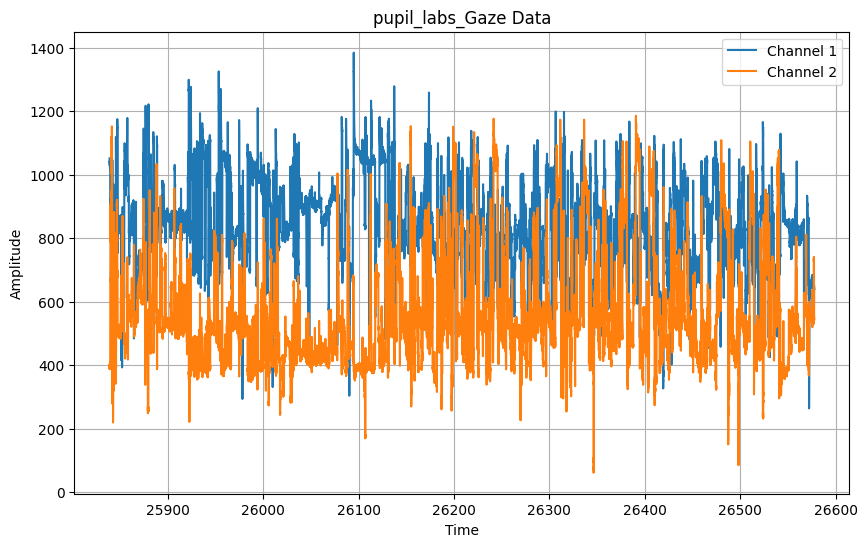

working on stream: BalanceBoard_stream  with a channel count of 4
 and a sampling rate of 500


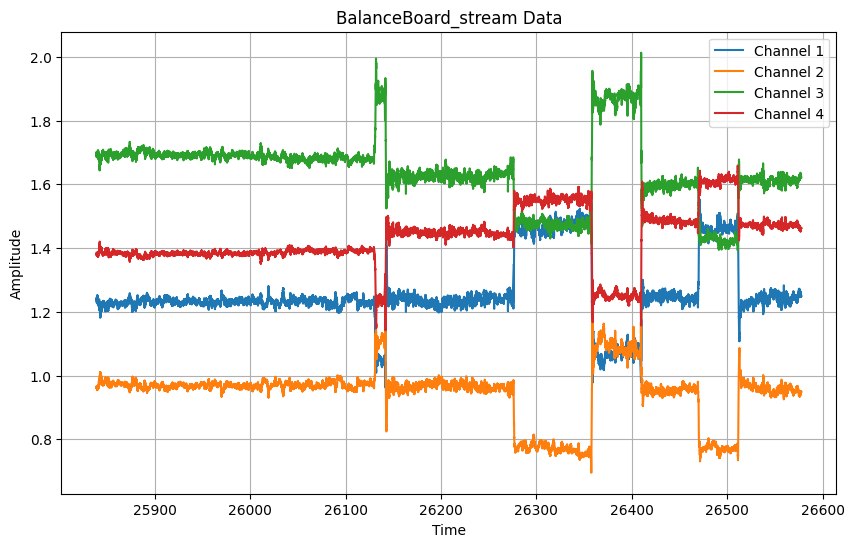

working on stream: MyWebcamFrameStream  with a channel count of 1
 and a sampling rate of 500


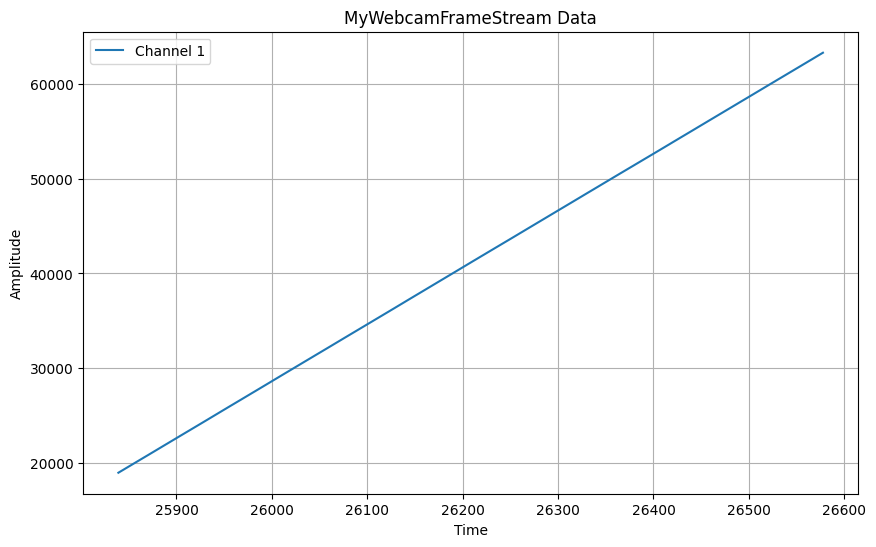

working on stream: OpenSignals  with a channel count of 3
 and a sampling rate of 1000


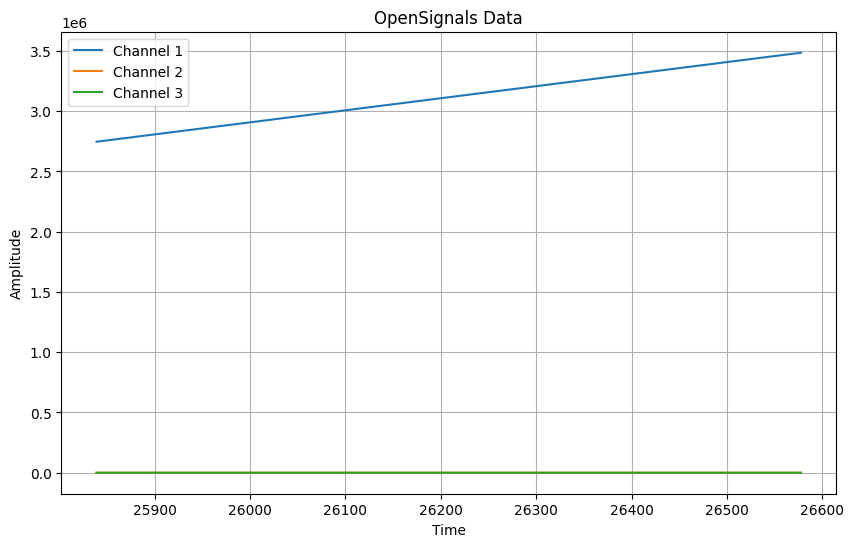

working on stream: Mic  with a channel count of 1
 and a sampling rate of 16000


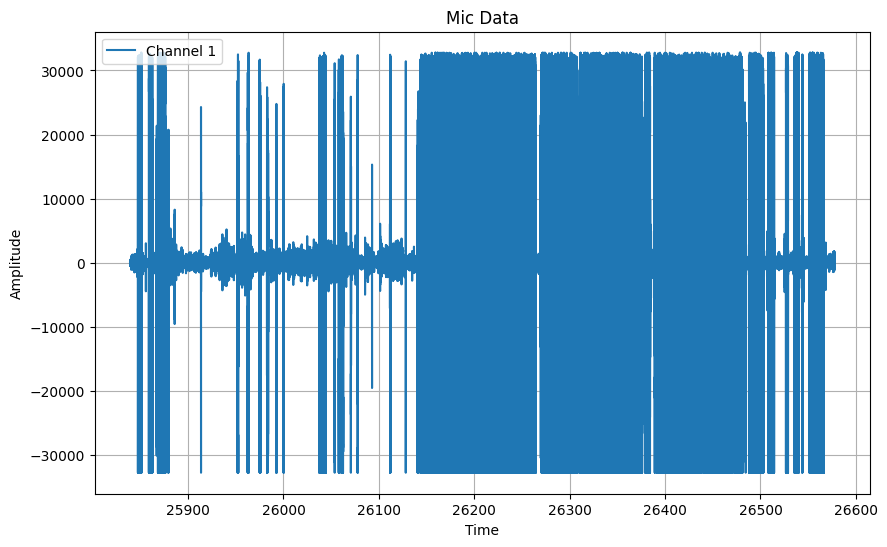

In [49]:
import matplotlib.pyplot as plt
for xdf_file in xdf_files:
    streams, header = pyxdf.load_xdf(xdf_file)
    fnam = os.path.basename(xdf_file)[:-4]
    
    for stream in streams:
        timeseriestype = stream['info']['name'][0]
        samplerate = round(float(stream['info']['nominal_srate'][0]))
        channelcount = stream['info']['channel_count'][0]
        
        print('working on stream: ' + timeseriestype + '  with a channel count of ' + str(channelcount) +'\n and a sampling rate of ' + str(samplerate))

        # Extracting time stamps and data
        timevec = stream['time_stamps']
        timeseries = stream['time_series']
        
        # Plotting the data
        plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
        for i in range(int(channelcount)):
            plt.plot(timevec, timeseries[:, i], label='Channel ' + str(i + 1))
        plt.title(timeseriestype + ' Data')
        plt.xlabel('Time')
        plt.ylabel('Amplitude')
        plt.legend()
        plt.grid(True)
        plt.show()


In [39]:
print(channelcount)

2
